# MAP Deblurer - color

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *

%matplotlib inline
import matplotlib.pyplot as plt

import scipy.io as io
#%env CUDA_VISIBLE_DEVICES=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MAP Denoiser

### Train MAP Denoiser
(skip if you want to use the provided model)  

In [ ]:
from MAPdenoiser import MAPdenoiser
DAE = MAPdenoiser(stddev=11.0/255., channels=3)

In [ ]:
DAE.train(epoch = 50, batch_size = 128, lr = 0.0001, phase = "train",
          ckpt_dir = './models/map_color', sample_dir ='./sample', test_dir ='./test',
          dataset_path = './data/img_clean_pats_rgb2.npy', eval_set ='Set12', test_set ='Set12',
          eval_every_epoch=1)

[*] Initialize model successfully...
[*] Loading data...
[*] Load successfully...
[*] Reading checkpoint...
[*] Not find pretrained model!
[*] Start training, with start epoch 0 start iter 0 : 
[*] Evaluating...
--- Test ---- Average PSNR 53.53 ---


In [ ]:
DAE.freeze_graph(ckpt_dir = './models/map_color')

### Test MAP Denoiser

['clean_image=>Placeholder', 'denoised=>Identity']
PSNR noisy: 27.304509929496955
Iter: 0 PSNR noisy: 30.623583998901506
Iter: 1 PSNR noisy: 33.79577776208396
Iter: 2 PSNR noisy: 35.664466972502545
Iter: 3 PSNR noisy: 35.796499999973534
Iter: 4 PSNR noisy: 35.14253501533612
Iter: 5 PSNR noisy: 34.39847238896745
Iter: 6 PSNR noisy: 33.73990064427528
Iter: 7 PSNR noisy: 33.17593493073698
Iter: 8 PSNR noisy: 32.68892820114027
Iter: 9 PSNR noisy: 32.262372072678595
Iter: 10 PSNR noisy: 31.883564233805988
Iter: 11 PSNR noisy: 31.542572421869245
Iter: 12 PSNR noisy: 31.23185422579806
Iter: 13 PSNR noisy: 30.945835397701636
Iter: 14 PSNR noisy: 30.68046699098456
Iter: 15 PSNR noisy: 30.4326724627771
Iter: 16 PSNR noisy: 30.200038826235406


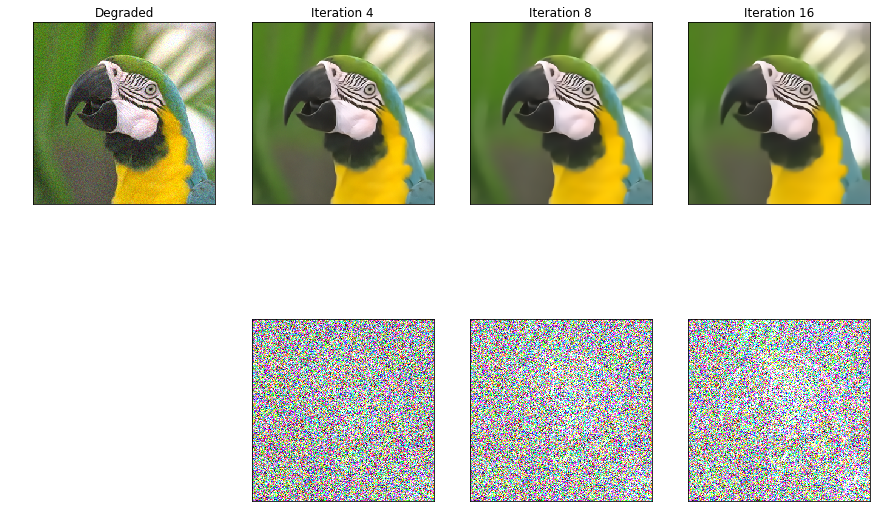

In [18]:
from MAPdenoiser import frozenMAPdenoiser
denoiser = frozenMAPdenoiser(channels=3, ckpt_dir = './models/map_color')

gt = np.array(Image.open('./data/images/kodim23.png').convert('RGB'), dtype='float32')[120:420,20:320,:]
noise = np.random.normal(0.0, 11.0, gt.shape).astype(np.float32)
degraded = gt + noise

print("PSNR noisy:", cal_psnr(degraded, gt))

plt.rc(('xtick','ytick'),color=(1,1,1,0))
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(241)
plt.imshow(np.squeeze(np.clip(degraded / 255,0,1)), cmap="gray")
plt.title('Degraded')

res = degraded.copy()
j = 0
for i in range(17):
    res = denoiser.denoise(res/255.0)*255
    print("Iter:", i, "PSNR noisy:", cal_psnr(res, gt))
    if i == 4 or i == 8 or i == 16:
        ax = plt.subplot(242+j)
        plt.imshow(np.squeeze(np.clip(res / 255 ,0,1)), cmap="gray")
        plt.title('Iteration ' +str(i))
        ax = plt.subplot(246+j)
        plt.imshow(np.squeeze(np.clip(np.abs(res-degraded)/10.0,0,1)))
        #plt.title('Residual at iteration ' + str(i))
        j = j + 1

plt.savefig("optimize_nonoise.png",dpi=400, bbox_inches='tight')

## Deblurring

### Test image + test kernel

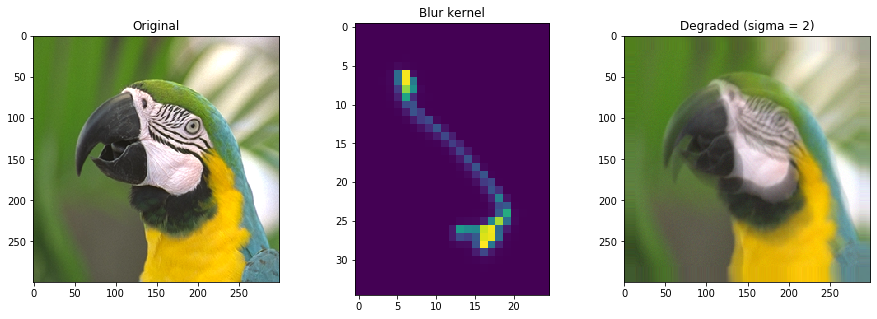

In [3]:
sigma_d = 255 * .01

kernel = io.loadmat('./data/kernels.mat')['kernels'][0,0]
kernel = kernel / np.sum(kernel[:])
fig = plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.imshow(kernel)
plt.title("Blur kernel")

gt = np.array(Image.open('./data/images/kodim23.png').convert('RGB'), dtype='float32')
gt = gt[120:420,20:320,:]
plt.subplot(131)
plt.title("Original")
plt.imshow(np.squeeze(gt / 255), cmap="gray")

initial = real_blur_and_noise(gt, kernel, sigma_d) 

img_degraded = Image.fromarray(np.clip(np.squeeze(initial), 0, 255).astype(dtype=np.uint8))
#img_degraded.save("data/degraded.png","png")

plt.subplot(133)
plt.imshow(img_degraded)
plt.title("Degraded (sigma = %d)" % sigma_d)
plt.show()

### Optimization

Iter. 5: PSNR is:30.038305650228672, iteration finished in 0.030158281326293945 seconds
Iter. 10: PSNR is:31.2393111871495, iteration finished in 0.02529001235961914 seconds
Iter. 15: PSNR is:31.64675321308682, iteration finished in 0.015474319458007812 seconds
Iter. 20: PSNR is:31.84764009989133, iteration finished in 0.015162944793701172 seconds
Iter. 25: PSNR is:31.969161928084347, iteration finished in 0.015362739562988281 seconds
Iter. 30: PSNR is:32.05374264092648, iteration finished in 0.015299081802368164 seconds
Iter. 35: PSNR is:32.113448416845955, iteration finished in 0.0325007438659668 seconds
Iter. 40: PSNR is:32.157620869727836, iteration finished in 0.015391349792480469 seconds
Iter. 45: PSNR is:32.19284969334116, iteration finished in 0.01498556137084961 seconds
Iter. 50: PSNR is:32.22120086095118, iteration finished in 0.014961004257202148 seconds
Iter. 55: PSNR is:32.243357154496806, iteration finished in 0.014786005020141602 seconds
Iter. 60: PSNR is:32.260989836736

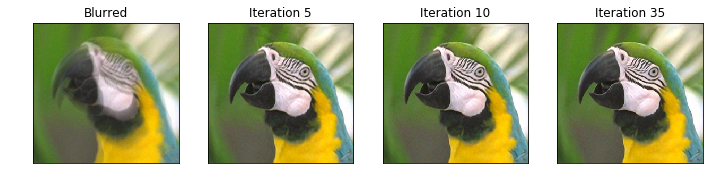

In [5]:
from fastMAPdeblurer import fastMAPDeblurer
sigma_dae = 11
rho = 1 / ((sigma_dae**2)-40) #small pertrubation to the rho helps the convergence (default 1 / (sigma_dae**2))

deblurer = fastMAPDeblurer(rho, sigma_d, gt.shape,
                           kernel_shape=kernel.shape,
                           denoiser = './models/map_color/optimizedMAPdenoiser.pb')

res = deblurer.optimize(initial, kernel, gt, nr_iters=75, test_iter=5, plot=True)
